In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
from tqdm.auto import tqdm

In [3]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use('seaborn-paper')
cmm = sns.color_palette("light:b", as_cmap=True)
cmf = sns.color_palette("light:orange", as_cmap=True)

In [4]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_04/longtogeny_males_clean.parquet')
mdf = pd.read_parquet(path)

In [5]:
#get rid of new recording sessions
mdf = mdf[mdf.index.get_level_values(0)<800]

In [ ]:
# remove later datapoints

In [ ]:
## filter out bad days - 
bad_session=[221, 228]

new_df.drop(bad_session, level=0, axis=0, inplace=True)


In [6]:
df_indv=mdf.groupby(['mouse','age']).mean()

In [7]:
df_indv.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54],
      dtype='int64', name='relabeled_syllables')

In [8]:
y = df_indv.to_numpy()
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True) # z-score

In [9]:
# run GLM for all data
indv_encoder = OneHotEncoder(sparse=False).fit_transform(df_indv.index.get_level_values(0).to_numpy().reshape(-1, 1))
age_encoder = OneHotEncoder(sparse=False).fit_transform(df_indv.index.get_level_values(1).to_numpy().reshape(-1, 1))
x = np.concatenate((age_encoder,indv_encoder), axis=1)
lr = ElasticNet(alpha=0.01)
lr.fit(x, y)

ElasticNet(alpha=0.01)

In [10]:
lr.score(x,y)

0.3552108661945509

In [11]:
## explained by indv at specific age

In [12]:
df = pd.DataFrame()
df['indv'] = df_indv.index.get_level_values(0).to_numpy()
df['age'] = df_indv.index.get_level_values(1).to_numpy()
syll=df_indv.columns.to_numpy()

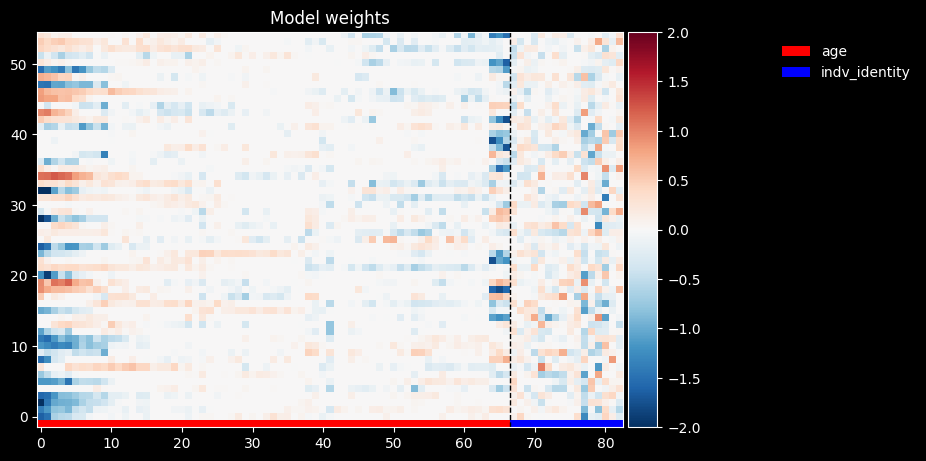

In [13]:
# plot weights for phase and individual identity
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
im=plt.imshow(lr.coef_, cmap='RdBu_r', vmin=-2, vmax=2)
#plt.imshow(lr.coef_, cmap='RdBu_r')
plt.title('Model weights')
ax = plt.gca()
rect = plt.Rectangle((-0.5, -1.5), age_encoder.shape[1], 1, facecolor='red', alpha=1, label='age')
ax.add_patch(rect)
rect = plt.Rectangle((age_encoder.shape[1]-0.5, -1.5), indv_encoder.shape[1], 1, facecolor='blue', alpha=1, label='indv_identity')
ax.add_patch(rect)
plt.axvline(age_encoder.shape[1] - 0.5, c='k', ls='--', lw=1)
plt.ylim(-1.5, y.shape[1] - 0.5)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)
#fig.savefig(data_loc + 'long_GLM_coefficients.pdf', bbox_inches='tight')

In [14]:
## compute multiple models

In [15]:
#load and prepare data
df = pd.DataFrame()
df['indv'] = df_indv.index.get_level_values(0).to_numpy()
df['phase'] = df_indv.index.get_level_values(1).to_numpy()
syll=df_indv.columns.to_numpy()

In [16]:
## for addition (no interaction)
ip = []
formula = 'syll ~ C(indv) + C(phase)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip.append(summary.rsquared)

In [17]:
## for addition and interactions per syllable
ip_intr = []
formula = 'syll ~ C(indv) + C(phase) + C(indv):C(phase)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ip_intr.append(summary.rsquared)

In [18]:
## for individual identity alone
## for phase alone
df['indv'] = df_indv.index.get_level_values(0).to_numpy()
df['phase'] = df_indv.index.get_level_values(1).to_numpy()
indv = []
formula = 'syll ~ C(indv)'
for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    indv.append(summary.rsquared)

In [19]:
## for shuffeled individual labels
a=df_indv.index.get_level_values(0).to_numpy()
formula = 'syll ~ C(new_indv)'
indv_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_indv=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_indv'] = np.random.permutation(a)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_indv.append(summary.rsquared)
    indv_shuff.append(np.mean(temp_indv))

  0%|          | 0/55 [00:00<?, ?it/s]

In [20]:
## for phase alone
df['indv'] = df_indv.index.get_level_values(0).to_numpy()
df['phase'] = df_indv.index.get_level_values(1).to_numpy()
ph = []
formula = 'syll ~ C(phase)'

for i in range(len(syll)):
    df['syll']=y[:,i]
    model = ols(formula, data=df)
    res=model.fit_regularized(method='elastic_net',alpha=0.01)
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    ph.append(summary.rsquared)

In [21]:
## for shuffeled phase labels
a=df_indv.index.get_level_values(1).to_numpy()
formula = 'syll ~ C(new_phase)'
phase_shuff = []
it=100
for i in tqdm(range(len(syll))):
    temp_phase=[]
    df['syll']=y[:,i]
    for j in range(it):
        df['new_phase'] = np.random.permutation(a)
        model = ols(formula, data=df)
        res=model.fit_regularized(method='elastic_net',alpha=0.01)
        pinv_wexog,_ = pinv_extended(model.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
        temp_phase.append(summary.rsquared)
    phase_shuff.append(np.mean(temp_phase))

  0%|          | 0/55 [00:00<?, ?it/s]

In [22]:
# create dataframe for plotting
r2 = np.concatenate((np.array(ip_intr),
                      np.array(ip),
                      np.array(ph),
                      np.array(phase_shuff),
                      np.array(indv),
                      np.array(indv_shuff)
                    ))
models = np.concatenate((len(np.array(ip_intr)) * ['Indv*Age'],
                         len(np.array(ip)) * ['I:A'],
                         len(np.array(ph)) * ['Age'],
                         len(np.array(phase_shuff)) * ['Age_sh'],
                         len(np.array(indv)) * ['Indv'],
                         len(np.array(indv_shuff)) * ['Indv_sh']
                        ))
lsyll = list(syll)*6
data = {'r2': list(r2), 
        'models': list(models),
        'syll':list(lsyll)}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


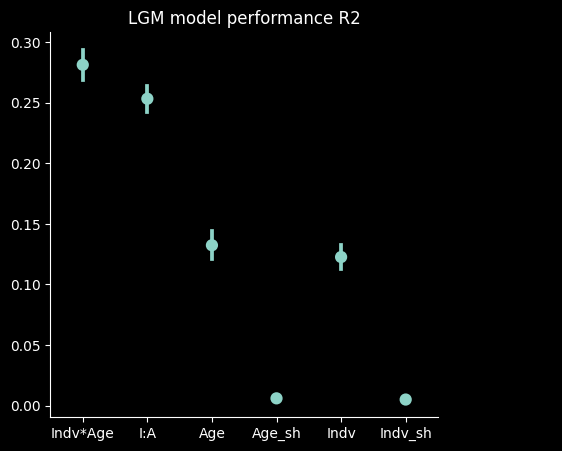

In [23]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
ax = sns.pointplot(x="models",y="r2",data=data,errorbar=('se'),join=False, 
                   order=['Indv*Age','I:A','Age','Age_sh','Indv','Indv_sh'])
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))
ax.set_title('LGM model performance R2')
sns.despine()
#fig.savefig(data_loc +'long_GLM_r2.pdf', bbox_inches='tight')

In [24]:
## indv vs age component in different ages

In [6]:
#get rid of new recording sessions
df_indv=mdf.groupby(['mouse','age']).mean()
df_indv = df_indv[df_indv.index.get_level_values(1)<800]

In [7]:
# get rid of all new ages

In [8]:
df=df_indv.copy().reset_index()

In [9]:
'''
#on pcs
pca = PCA(n_components=10)
pcs=pca.fit_transform(np.log(df_indv + 1e-6))
pc_df = pd.DataFrame(pcs)
pc_df['age'] = df['age']
pc_df['mouse'] = df['mouse']
df=pc_df.copy()
'''

"\n#on pcs\npca = PCA(n_components=10)\npcs=pca.fit_transform(np.log(df_indv + 1e-6))\npc_df = pd.DataFrame(pcs)\npc_df['age'] = df['age']\npc_df['mouse'] = df['mouse']\ndf=pc_df.copy()\n"

In [10]:
xmale = pd.DataFrame()
a=0
n=25 # number of consecutive days for calculate over
age=[]
indv=[]
time=[]
score=[]
b=False

while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
    # run GLM
    # prepare syllable data
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    y = xmale.drop(['mouse','age'], axis=1).to_numpy()
    y_log = np.log(y + 1e-6)
    y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True) # z-score
    # prepare predictors
    indv_encoder = OneHotEncoder(sparse=False).fit_transform(xmale['mouse'].to_numpy().reshape(-1, 1))
    age_encoder = OneHotEncoder(sparse=False).fit_transform(xmale['age'].to_numpy().reshape(-1, 1))
    lr = ElasticNet(alpha=0.01)
    lr.fit(indv_encoder, y)
    indv.append(lr.score(indv_encoder,y))
    lr.fit(age_encoder, y)
    time.append(lr.score(age_encoder,y))
    
    x = np.concatenate((age_encoder,indv_encoder), axis=1)
    lr = ElasticNet(alpha=0.01)
    lr.fit(x, y)
    score.append(lr.score(x,y))
    
    # handle variables for the loop
    xmale = pd.DataFrame()
    #temp_acc=[]
    a=a+1

(('r2', 120), ('models', 120), ('ages', 120))


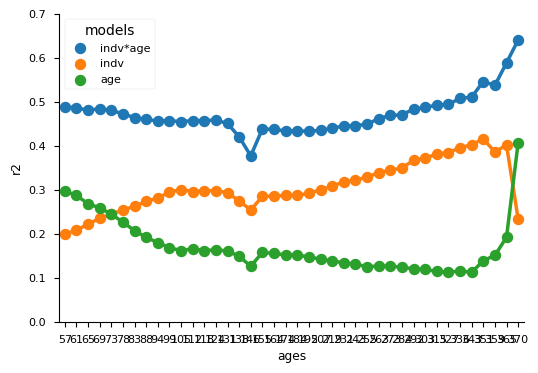

In [12]:
# plot
r2 = np.concatenate((np.array(score),
                      np.array(indv),
                      np.array(time)
                    ))
models = np.concatenate((len(np.array(score)) * ['indv*age'],
                         len(np.array(indv)) * ['indv'],
                         len(np.array(time)) * ['age']
                        ))

ages = list(age)*3
#data=pd.DataFrame()
data = {'r2': list(r2), 
        'models': list(models),
        'ages':list(ages)}
print(tuple((k, len(v)) for k, v in data.items()))
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=pd.DataFrame(data), x="ages", y="r2",hue='models', ax=ax,join=True)
#plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,0.7])
sns.despine()

In [95]:
xmale = pd.DataFrame()
a=0
n=20 # number of consecutive days for calculate over
age=[]
indv=[]
time=[]
score=[]
b=False

while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
    # run GLM
    # prepare syllable data
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    y = xmale.drop(['mouse','age'], axis=1).to_numpy()
    y_log = np.log(y + 1e-6)
    y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True) # z-score
    # prepare predictors
    indv_encoder = OneHotEncoder(sparse=False).fit_transform(xmale['mouse'].to_numpy().reshape(-1, 1))
    age_encoder = OneHotEncoder(sparse=False).fit_transform(xmale['age'].to_numpy().reshape(-1, 1))
    x = np.concatenate((age_encoder,indv_encoder), axis=1)
    lr = ElasticNet(alpha=0.01)
    lr.fit(x, y)
    score.append(lr.score(x,y))
    # calcualte score on suffles indv (so just for age)
    new_indv = np.random.permutation(indv_encoder)
    x = np.concatenate((age_encoder,new_indv), axis=1)
    time.append(lr.score(x,y))
    # calcualte score on suffles age (so just indv)
    new_age = np.random.permutation(age_encoder)
    x = np.concatenate((new_age,indv_encoder), axis=1)
    indv.append(lr.score(x,y))
    # handle variables for the loop
    xmale = pd.DataFrame()
    #temp_acc=[]
    a=a+1

(('r2', 144), ('models', 144), ('ages', 144))


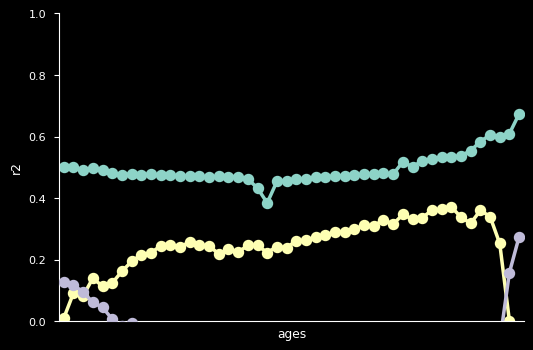

In [97]:
# plot
r2 = np.concatenate((np.array(score),
                      np.array(indv),
                      np.array(time)
                    ))
models = np.concatenate((len(np.array(score)) * ['score'],
                         len(np.array(indv)) * ['indv'],
                         len(np.array(time)) * ['time']
                        ))

ages = list(age)*3
#data=pd.DataFrame()
data = {'r2': list(r2), 
        'models': list(models),
        'ages':list(ages)}
print(tuple((k, len(v)) for k, v in data.items()))
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=pd.DataFrame(data), x="ages", y="r2", hue='models', ax=ax,join=True)
plt.legend([],[], frameon=False)
plt.xticks([])
ax.set_ylim([0,1])
sns.despine()